# Averaged data

In [2]:
from pandas import HDFStore, DataFrame, Series
from tqdm.auto import tqdm
from pandas import concat


def load_averaged_data(path: str) -> tuple[DataFrame, Series, Series]:
    loaded_data: dict[str, DataFrame] = {}

    # Open the HDF5 file
    with HDFStore(path) as store:
        # Iterate through the keys (group names) in the HDF5 file
        for key in tqdm(store.keys(), desc='Loading data'):
            # Load each DataFrame and store it in the dictionary
            loaded_data[key] = store[key]

    concated_df_avgs = concat(
        [loaded_data[key][("Average", "Balanced Accuracy")] for key in loaded_data.keys()],
        axis=1,
        keys=[el[1:] for el in loaded_data.keys()],
    )
    concated_df_errs = concat(
        [loaded_data[key][("Standard error", "Balanced Accuracy")] for key in loaded_data.keys()],
        axis=1,
        keys=[el[1:] for el in loaded_data.keys()],
    )
    df_avgs = concated_df_avgs.unstack().reset_index()
    df_avgs.columns = ["side", "classifier", "Balanced Accuracy"]

    df_errs = concated_df_errs.unstack().reset_index()
    df_errs.columns = ["side", "classifier", "Balanced Accuracy"]
    upper_errs = df_errs["Balanced Accuracy"]
    lower_errs = df_errs["Balanced Accuracy"]
    return df_avgs, upper_errs, lower_errs, df_errs
    
def make_linerrorplot(data: DataFrame, lower_errs: Series, upper_errs: Series, path_to_save: str) -> None:
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    
    plt.figure(figsize=(3, 7))
    sns.set_style("darkgrid")
    
    palette = sns.color_palette("colorblind")
    # sns.scatterplot(data=df, x='side', y='Balanced Accuracy', hue='classifier')
    plt.errorbar(
        x=data["side"],
        y=data["Balanced Accuracy"],
        xerr=None,
        yerr=(lower_errs, upper_errs),
        # label=custom_label,
        elinewidth=5,
        linestyle="none",
        markersize=1,
        marker=".",
        color=palette[0],
        ecolor=(*palette[0], 0.3),
    )
    plt.ylim(0.5, 1.0)
    
    plt.savefig(path_to_save, bbox_inches="tight")
    plt.show()
    # legend off
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    # 

## USILaughs - all max resources

In [2]:
path_to_save_data_avgs = "../data.nosync/usilaughs/results/nested_partial_temporal_consistency_avg_bilateral_COMPLETE.h5"
# Create an empty dictionary to store the loaded DataFrames
df_avgs, upper_errs, lower_errs, df_errs = load_averaged_data(path_to_save_data_avgs)

Loading data:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
display(
    concat([df_errs["Balanced Accuracy"], df_avgs], axis=1, keys=["errors", "averages"])
    .groupby(("averages", "side"))
    .max()*100
)


errors  \
                 Balanced Accuracy   
(averages, side)                     
diff                      0.499166   
left                      0.538538   
left+diff                 0.509976   
left+right                0.535948   
left+right+diff           0.520809   
right                     0.545741   
right+diff                0.494814   

                                                           averages  \
                                                         classifier   
(averages, side)                                                      
diff              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
left              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
left+diff         XGBClassifierXGBClassifierXGBClassifierXGBClas...   
left+right        XGBClassifierXGBClassifierXGBClassifierXGBClas...   
left+right+diff   XGBClassifierXGBClassifierXGBClassifierXGBClas...   
right             XGBClassifierXGBClassifierXGBClassifierXGBClas...   
right+diff        XGBClassifierXGBClassifierXGBClassifierXGBClas...   

                                    
                 Balanced Accuracy  
(averages, side)                    
diff                     70.411333  
left                     74.087333  
left+diff                81.630667  
left+right               83.180667  
left+right+diff          83.433333  
right                    78.862667  
right+diff               82.028667

## MWC2022

In [3]:
path_to_save_data_avgs = "../data.nosync/mwc2022/results/nested_partial_temporal_consistency_avg_bilateral.h5"
# Create an empty dictionary to store the loaded DataFrames
df_avgs, upper_errs, lower_errs, df_errs = load_averaged_data(path_to_save_data_avgs)

Loading data:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
display(
    concat([df_errs["Balanced Accuracy"], df_avgs], axis=1, keys=["errors", "averages"])
    .groupby(("averages", "side"))
    .max()*100
)


errors  \
                 Balanced Accuracy   
(averages, side)                     
diff                      0.416494   
left                      0.323649   
left+diff                 0.333682   
left+right                0.272454   
left+right+diff           0.284937   
right                     0.261632   
right+diff                0.291574   

                                                           averages  \
                                                         classifier   
(averages, side)                                                      
diff              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
left              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
left+diff         XGBClassifierXGBClassifierXGBClassifierXGBClas...   
left+right        XGBClassifierXGBClassifierXGBClassifierXGBClas...   
left+right+diff   XGBClassifierXGBClassifierXGBClassifierXGBClas...   
right             XGBClassifierXGBClassifierXGBClassifierXGBClas...   
right+diff        XGBClassifierXGBClassifierXGBClassifierXGBClas...   

                                    
                 Balanced Accuracy  
(averages, side)                    
diff                     75.437591  
left                     76.044784  
left+diff                77.780995  
left+right               76.832656  
left+right+diff          79.195174  
right                    75.264670  
right+diff               79.273720

# Total data

In [1]:
from pandas import DataFrame, concat, MultiIndex, Series
from collections import defaultdict
from pandas import concat
from numpy import nanstd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import itertools
from pandas import HDFStore, DataFrame
from tqdm.auto import tqdm
from scipy.stats import shapiro, anderson, ttest_ind
from statsmodels.stats.multitest import multipletests


def calculate_fold_df(data: DataFrame):
    avgs = concat(
        [fold_res["Balanced Accuracy"] for fold_res in data.values()],
        axis=1,
        keys=range(5),
    ).mean(axis=1)
    errs = concat(
        [fold_res["Balanced Accuracy"] for fold_res in data.values()],
        axis=1,
        keys=range(5),
    ).apply(lambda x: nanstd(x) / ((len(x - 1)) ** 0.5) if len(x) > 1 else 1, axis=1)
    return concat([avgs, errs], axis=1, keys=["Balanced Accuracy", "Standard Error"])


def concatenate_prepared_data(data: dict[str, DataFrame], sides: list[str] = ["left", "right", "lxrx", "rxlx"]) -> DataFrame:
    concated_df_dict: dict[DataFrame, Series] = {}
    for side in sides:
        concated_df_dict[side] = concat(
            [
                data[key][["Balanced Accuracy", "Standard Error"]].sort_index()
                for key in data.keys()
                if side in key
            ],
            axis=0,
            keys=[key[1:5] for key in data.keys() if side in key],
        )
        concated_df_dict[side].index = concated_df_dict[side].index.droplevel(0)

    all_results = concat(
        list(concated_df_dict.values()),
        axis=0,
        keys=sides,
        # ignore_index=True,
    )
    all_results = all_results.reset_index()
    all_results.columns = ["Side", "Model", "Balanced Accuracy", "Standard Error"]
    return all_results


import pandas as pd
def load_prepare_data(path_to_all_data: str) -> DataFrame:
    # loaded_data = defaultdict(lambda: defaultdict(lambda: dict()))

    # Open the HDF5 file
    with HDFStore(path_to_all_data) as store:
        # Iterate through the keys (group names) in the HDF5 file
        loaded_data = {
            key: store[key]
            for key in tqdm(store.keys(), desc="Loading data")
        }
        all_results = pd.concat(loaded_data.values(), axis=0, keys=loaded_data.keys(), names=["ID", "Model"])
        all_results = all_results.reset_index(inplace=False, drop=False)
        all_results['Side'] = all_results['ID'].apply(lambda x: x.split("_")[0])
        all_results['Random Seed'] = all_results['ID'].apply(lambda x: x.split("_")[1])
        all_results['Outer fold'] = all_results['ID'].apply(lambda x: x.split("_")[2])
        all_results = all_results.drop(columns=['ID'])
        return all_results
    #     for i, key in tqdm(enumerate(store.keys()), desc="Loading data", total=len(store.keys())):
    #         # Load each DataFrame and store it in the dictionary
    #         data = store[key]
    #         split_key = key.split("_")
    #         loaded_data[split_key[0]][i] = data

    # sides = set([key1 for key1 in loaded_data.keys()])
    # loaded_data_correct = {
    #     f"{key1}_{key2}": calculate_fold_df(loaded_data[key1][key2])
    #     for key1 in loaded_data.keys()
    #     for key2 in loaded_data[key1].keys()
    # }

    # return concatenate_prepared_data(data=loaded_data_correct, sides=sides)


def remove_dummy(data: DataFrame) -> DataFrame:
    return data[data["Model"] != "DummyClassifier"]


def make_violin_accuracy(
    data: DataFrame,
    path_to_save_fig: str | None = None,
    small_fontsize: int = 14,
    medium_fontsize: int = 18,
    large_fontsize: int = 20,
    xlim: tuple[float, float] | None = None,
):
    # set seaborn style
    sns.set_style("darkgrid")

    # # set latex font
    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"
    # plt.rcParams.update({"font.size": figsize *8})
    plt.rcParams["axes.grid"] = True

    # increase font size
    plt.rc("font", size=small_fontsize)  # controls default text sizes
    plt.rc("axes", titlesize=medium_fontsize)  # fontsize of the axes title
    plt.rc("axes", labelsize=large_fontsize)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=small_fontsize)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=small_fontsize)  # fontsize of the tick labels
    plt.rc("legend", fontsize=medium_fontsize)  # legend fontsize
    plt.rc("figure", titlesize=large_fontsize)  # fontsize of the figure title
    plt.rcParams.update({"font.size": medium_fontsize})

    ax = sns.violinplot(
        data=data,
        y="Train-Test",
        x="Balanced Accuracy",
        palette="colorblind",
        orient="h",
        # inner='point',
        cut=0,
        
    )
    # annotator = Annotator(
    #     ax,
    #     list(itertools.combinations(sides, 2)),
    #     data=data,
    #     x="Balanced Accuracy",
    #     y="Train-Test",
    #     orient="h",
    #     order=sides,
    # )
    # annotator.configure(
    #     test="Wilcoxon",
    #     comparisons_correction="HB",
    #     text_format="star",
    #     loc="outside",
    # )
    # annotator.apply_and_annotate()

    # set vertical line at 0.5
    plt.axvline(x=0.5, color="black", linestyle="--", linewidth=1)
    if xlim:
        plt.xlim(xlim)
    if path_to_save_fig is not None:
        plt.savefig(path_to_save_fig, bbox_inches="tight")
    plt.show()


def clean_side_names(
    data: DataFrame, renaming_dict: dict[str, str] | None = None
) -> DataFrame:
    if renaming_dict is None:
        renaming_dict = {
            "left": "Left-Left",
            "right": "Right-Right",
            "lxrx": "Left-Right",
            "rxlx": "Right-Left",
        }
    # renaming_dict: dict[str, str]
    data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)
    return data.rename(columns={"Side": "Train-Test"}, inplace=False)

    

def test_normality(all_xgb_results: dict) -> None:
    # test the normality of all three data distributions
    for side, data in all_xgb_results.items():
        print(f"Shapiro-Wilk test for normality on data set {side}:")
        print(shapiro(data["Balanced Accuracy"]))
        # make the histogram with kernel of the data distribution
        sns.distplot(
            data["Balanced Accuracy"],
            hist=True,
            kde=True,
            color="darkblue",
            hist_kws={"edgecolor": "black"},
            kde_kws={"linewidth": 4},
        )
        plt.show()
        print(f"Anderson-Darling test for normality on data set {side}:")
        print(anderson(data["Balanced Accuracy"]))


def simple_t_test(
    side_combinations: list[str], all_xgb_results: dict[str, DataFrame]
) -> dict[str, tuple]:
    t_test_results = {}
    for combination in side_combinations:
        el1 = all_xgb_results[combination[0]]["Balanced Accuracy"]
        el2 = all_xgb_results[combination[1]]["Balanced Accuracy"]
        t, p = ttest_ind(el1, el2)
        t_test_results[combination] = (t, p, p > 0.05)
    return t_test_results

from scipy import stats
from numpy import ndarray, mean, sqrt


def corrected_repeated_kfold_cv_test(
    a: ndarray, b: ndarray, n2: int, n1: int
) -> tuple[float, float]:
    if not isinstance(a, ndarray) or not isinstance(b, ndarray):
        raise ValueError("Inputs must be numpy arrays")
    x = a - b
    m = mean(x)
    sigma_squared = ((x - m) ** 2 / (len(x) - 1)).sum()
    denominator = 1 / len(x) + n2 / n1
    t = m / sqrt(denominator * sigma_squared)
    pval = stats.t.sf(abs(t), len(x)-1 + n1/n2) * 2
    return t, pval


def corrected_t_test(
    side_combinations: list[str], df: dict[str, DataFrame], n1, n2
) -> dict[str, tuple]:
    t_test_results = {}
    for combination in side_combinations:
        el1 = df[df['Train-Test'] == combination[0]]["Balanced Accuracy"]
        el2 = df[df['Train-Test'] == combination[1]]["Balanced Accuracy"]
        t, p = corrected_repeated_kfold_cv_test(el1.values, el2.values, n1=n1, n2=n2)
        t_test_results[combination] = (t, p, p > 0.05)
    
    p_values = [el[1] for el in t_test_results.values()]
    # apply p-value correction
    multi_hypothesis_result = multipletests(
    p_values,
    alpha=0.05,
    method="holm",
)   
    t_test_results = {
        key: (value[0], multi_hypothesis_result[1][i], value[2])
        for i, (key, value) in enumerate(t_test_results.items())
    }
    return t_test_results


def cleanup_opposite_side_name(side_name: str) -> str:
    side_name = side_name[2:-1]
    sides = side_name.split(", ")
    train_side_name = sides[0]
    test_side_name = sides[1]
    return f"{train_side_name} -- {test_side_name}"

## USILaughs

In [2]:
path_to_save_data_avgs = "../data.nosync/usilaughs/results/nested_partial_temporal_consistency_all_bilateral_COMPLETE.h5"

# Create an empty dictionary to store the loaded DataFrames
all_results = load_prepare_data(path_to_save_data_avgs)

all_results_no_dummy = remove_dummy(data=all_results)

renaming_dict = {
    side_name: f"{side_name[1:]} -- {side_name[1:]}" if "(" not in side_name 
    else cleanup_opposite_side_name(side_name) 
    for side_name in all_results_no_dummy['Side'].unique()
}
all_results_no_dummy = clean_side_names(data=all_results_no_dummy,
                                        renaming_dict=renaming_dict)


Loading data:   0%|          | 0/4375 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_96737/3793994408.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)


The current dataframe contains the results for all of the seeds and outer folds. Since we want one value for each of iteration, we need to average over the outer fold results.

In [3]:
all_seed_avgs = all_results_no_dummy.groupby(["Train-Test", "Model", 'Random Seed']).mean(numeric_only=True)
all_seed_avgs = all_seed_avgs.reset_index(drop=False)

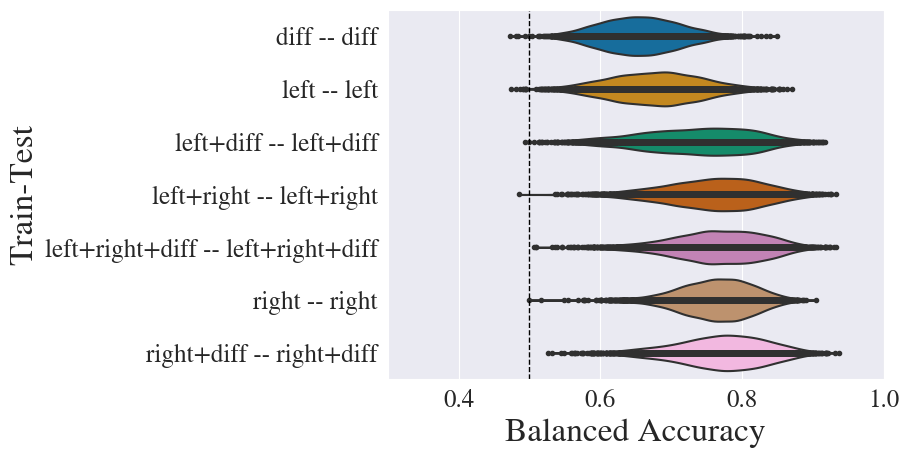

In [4]:
make_violin_accuracy(
    data=all_seed_avgs,
    path_to_save_fig="../final_visualizations/violin_nested_partial_temporal_consistency_accuracy_usilaughs.pdf",
    # path_to_save_fig=None,
    xlim=(0.3,1),
    small_fontsize=18, 
    medium_fontsize=24,
    large_fontsize=25,
)


THE ERROR CALCULATION IS WRONG

In [8]:
average_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].mean()
# NOTE: this error estimation is not actually correct.
err_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].std() / (all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].count().apply(lambda x: x**0.5))
for i in range(len(average_acc)):
    # print accuracy with format '0.2f' (2 decimal places)
    print('Average accuracy for {} side: {:.2f} ± {:.2f}'.format(average_acc.index[i], average_acc[i]*100, err_acc[i]*100))

Average accuracy for diff -- diff side: 69.89 ± 0.42
Average accuracy for left -- left side: 73.70 ± 0.35
Average accuracy for left+diff -- left+diff side: 81.56 ± 0.32
Average accuracy for left+right -- left+right side: 82.08 ± 0.33
Average accuracy for left+right+diff -- left+right+diff side: 84.19 ± 0.31
Average accuracy for right -- right side: 77.69 ± 0.41
Average accuracy for right+diff -- right+diff side: 81.34 ± 0.34


In [9]:
max_acc = all_seed_avgs.groupby('Train-Test').max()
display(max_acc[['Balanced Accuracy']]*100)

,Balanced Accuracy
Train-Test,
diff -- diff,81.416667
left -- left,81.333333
left+diff -- left+diff,90.750000
left+right -- left+right,90.666667
left+right+diff -- left+right+diff,92.250000
right -- right,88.666667
right+diff -- right+diff,90.250000


### Statistical Tests

In [13]:
side_testing = all_results_no_dummy["Train-Test"].unique().tolist()

all_xgb_results = {
    train_test_paradigm: all_results_no_dummy[
        (all_results_no_dummy["Train-Test"] == train_test_paradigm)
        & (all_results_no_dummy["Model"] == "XGBClassifier")
    ]
    for train_test_paradigm in side_testing
}

# get all possible combinations for the side_testing list

side_combinations = list(itertools.combinations(side_testing, 2))

Shapiro-Wilk test for normality on data set diff -- diff:
ShapiroResult(statistic=0.9786413311958313, pvalue=6.574614275223212e-08)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


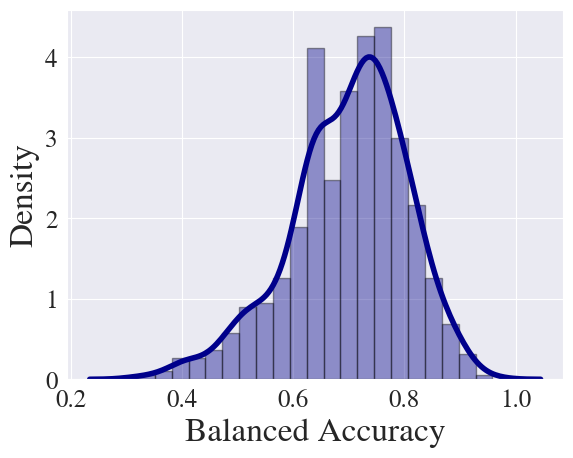

Anderson-Darling test for normality on data set diff -- diff:
AndersonResult(statistic=3.374834776887724, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.6989066666666666, scale=0.10471423474378834)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set left+diff -- left+diff:
ShapiroResult(statistic=0.9887199997901917, pvalue=9.695762128103524e-05)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


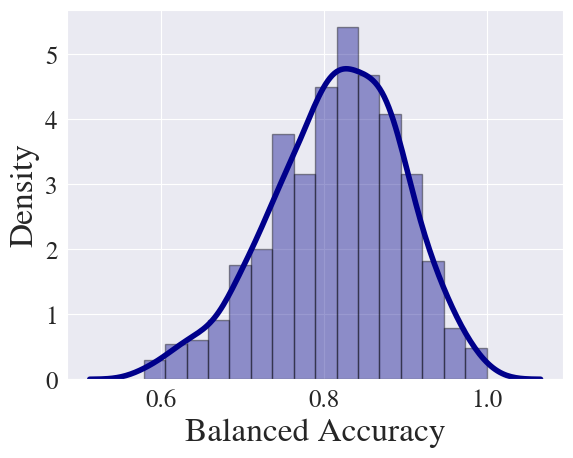

Anderson-Darling test for normality on data set left+diff -- left+diff:
AndersonResult(statistic=1.6437036577933668, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.8155933333333334, scale=0.08001950216350842)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set left+right+diff -- left+right+diff:
ShapiroResult(statistic=0.9898145198822021, pvalue=0.0002516272070351988)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


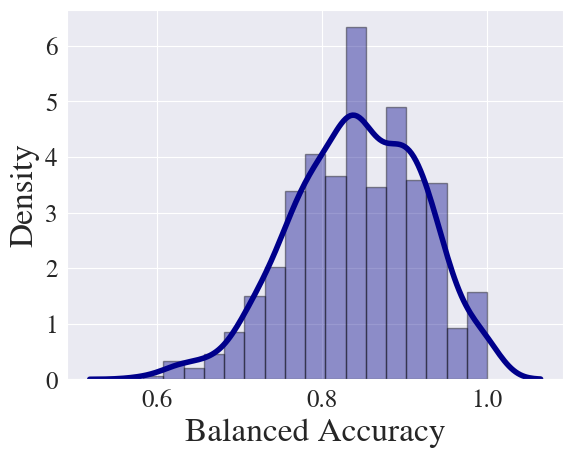

Anderson-Darling test for normality on data set left+right+diff -- left+right+diff:
AndersonResult(statistic=1.111002155285064, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.8418866666666667, scale=0.07835938089843696)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set left+right -- left+right:
ShapiroResult(statistic=0.9929009675979614, pvalue=0.00462596770375967)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


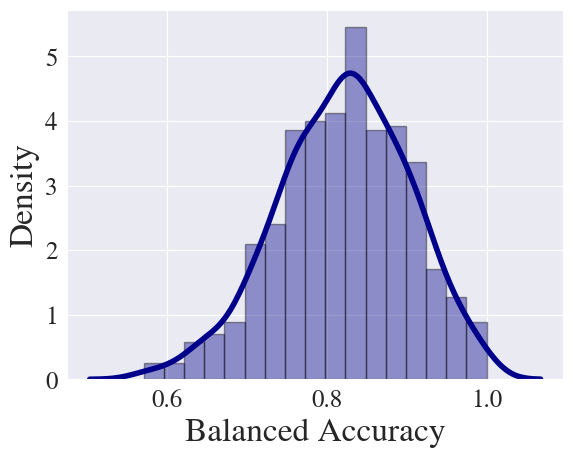

Anderson-Darling test for normality on data set left+right -- left+right:
AndersonResult(statistic=0.7056238102286443, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.8208066666666666, scale=0.08174637005454138)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set left -- left:
ShapiroResult(statistic=0.9970706701278687, pvalue=0.32505184412002563)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


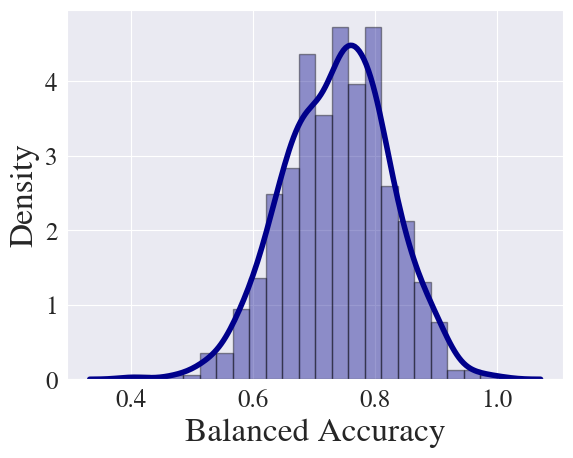

Anderson-Darling test for normality on data set left -- left:
AndersonResult(statistic=0.5401860318431773, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.7370333333333334, scale=0.08650452504097171)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set right+diff -- right+diff:
ShapiroResult(statistic=0.9866423606872559, pvalue=1.7575279343873262e-05)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


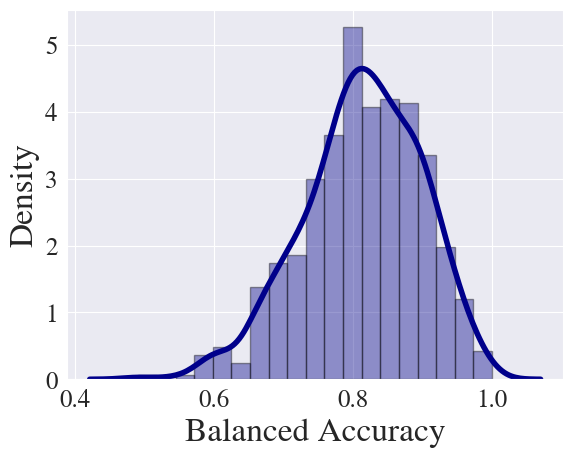

Anderson-Darling test for normality on data set right+diff -- right+diff:
AndersonResult(statistic=1.6115431056666694, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.8133733333333334, scale=0.08436222837812594)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set right -- right:
ShapiroResult(statistic=0.9869548678398132, pvalue=2.2540132704307325e-05)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


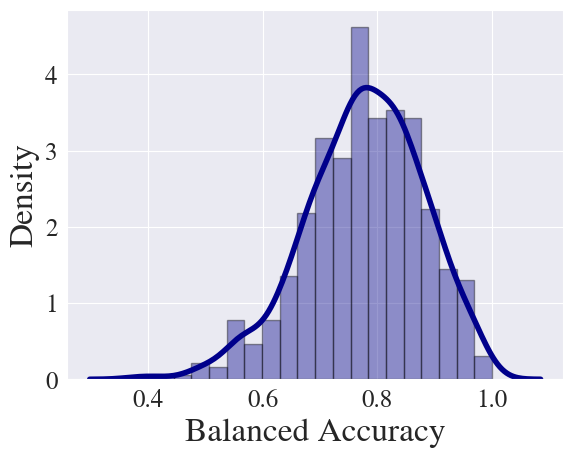

Anderson-Darling test for normality on data set right -- right:
AndersonResult(statistic=1.2611024459324653, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.7769333333333333, scale=0.10209007042133177)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [11]:
test_normality(all_xgb_results=all_xgb_results)

Statistical tests say that the distributions are not normal. But upon visual inspection, they are not far from a normal. As such, the t-test should be able handle this data, since with n>30 it is still robust to non-normality.

In [11]:
n_tot = 810
n1 = 4/5 * n_tot
n2 = 1/5 * n_tot

In [14]:
t_test_results = corrected_t_test(df=all_seed_avgs, 
                               side_combinations=side_combinations, n1=n1, n2=n2)

This t test evaluated the mean and standard deviation directly. However, a stronger approach would be to use the calculate standard deviation. I perform this in the average part.

In [15]:
t_test_results = pd.DataFrame.from_dict(t_test_results, orient='index', columns=['t', 'p-value', 'p > 0.05'])
display(t_test_results)

,t,p-value,p > 0.05
"(diff -- diff, left+diff -- left+diff)",-2.078994,0.490090,False
"(diff -- diff, left+right+diff -- left+right+diff)",-3.201404,0.027626,False
"(diff -- diff, left+right -- left+right)",-2.777107,0.099309,False
"(diff -- diff, left -- left)",-0.642784,1.000000,True
"(diff -- diff, right+diff -- right+diff)",-3.266726,0.023094,False
"(diff -- diff, right -- right)",-3.016317,0.049006,False
"(left+diff -- left+diff, left+right+diff -- left+right+diff)",-0.797300,1.000000,True
"(left+diff -- left+diff, left+right -- left+right)",-0.630966,1.000000,True
"(left+diff -- left+diff, left -- left)",1.519114,1.000000,True
"(left+diff -- left+diff, right+diff -- right+diff)",-0.884317,1.000000,True


## MWC2022

In [53]:
path_to_save_data_avgs = "../data.nosync/mwc2022/results/nested_all_bilateral.h5"

# Create an empty dictionary to store the loaded DataFrames
all_results = load_prepare_data(path_to_save_data_avgs)

all_results_no_dummy = remove_dummy(data=all_results)

renaming_dict = {
    side_name: f"{side_name[1:]} -- {side_name[1:]}" if "(" not in side_name 
    else cleanup_opposite_side_name(side_name) 
    for side_name in all_results_no_dummy['Side'].unique()
}
all_results_no_dummy = clean_side_names(data=all_results_no_dummy,
                                        renaming_dict=renaming_dict)


Loading data:   0%|          | 0/5125 [00:00<?, ?it/s]

In [54]:
all_seed_avgs = all_results_no_dummy.groupby(["Train-Test", "Model", 'Random Seed']).mean(numeric_only=True)
all_seed_avgs = all_seed_avgs.reset_index(drop=False)

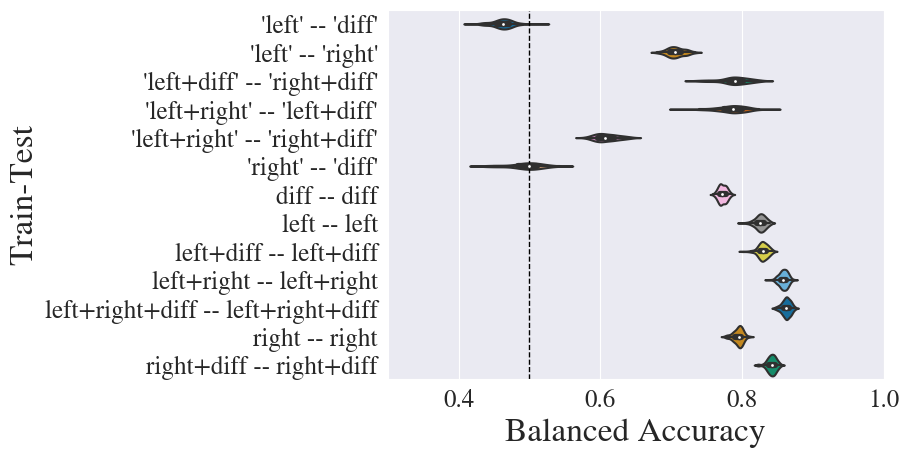

In [56]:
make_violin_accuracy(
    data=all_seed_avgs,
    # path_to_save_fig="../final_visualizations/violin_nested_accuracy_mwc2022.pdf",
    path_to_save_fig=None,
    xlim=(0.3,1),
    small_fontsize=18, 
    medium_fontsize=24,
    large_fontsize=25,
)


In [57]:
average_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].mean()
# NOTE: this error estimation is not actually correct.
err_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].std() / (all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].count().apply(lambda x: x**0.5))
for i in range(len(average_acc)):
    # print accuracy with format '0.2f' (2 decimal places)
    print('Average accuracy for {} side: {:.2f} ± {:.2f}'.format(average_acc.index[i], average_acc[i]*100, err_acc[i]*100))

Average accuracy for 'left' -- 'diff' side: 46.28 ± 0.14
Average accuracy for 'left' -- 'right' side: 70.64 ± 0.11
Average accuracy for 'left+diff' -- 'right+diff' side: 78.98 ± 0.18
Average accuracy for 'left+right' -- 'left+diff' side: 78.55 ± 0.19
Average accuracy for 'left+right' -- 'right+diff' side: 60.89 ± 0.14
Average accuracy for 'right' -- 'diff' side: 49.46 ± 0.21
Average accuracy for diff -- diff side: 77.25 ± 0.07
Average accuracy for left -- left side: 82.58 ± 0.09
Average accuracy for left+diff -- left+diff side: 82.94 ± 0.08
Average accuracy for left+right -- left+right side: 85.83 ± 0.07
Average accuracy for left+right+diff -- left+right+diff side: 86.24 ± 0.07
Average accuracy for right -- right side: 79.46 ± 0.08
Average accuracy for right+diff -- right+diff side: 84.17 ± 0.07


In [60]:
max_acc = all_seed_avgs.groupby('Train-Test').max()
display(max_acc[['Balanced Accuracy']]*100)

,Balanced Accuracy
Train-Test,
'left' -- 'diff',51.537607
'left' -- 'right',73.368750
'left+diff' -- 'right+diff',82.790514
'left+right' -- 'left+diff',83.798978
'left+right' -- 'right+diff',64.509196
'right' -- 'diff',54.327647
diff -- diff,78.541583
left -- left,84.023314
left+diff -- left+diff,84.391450


### Statistical Tests

In [61]:
side_testing = all_results_no_dummy["Train-Test"].unique().tolist()

all_xgb_results = {
    train_test_paradigm: all_results_no_dummy[
        (all_results_no_dummy["Train-Test"] == train_test_paradigm)
        & (all_results_no_dummy["Model"] == "XGBClassifier")
    ]
    for train_test_paradigm in side_testing
}

# get all possible combinations for the side_testing list

side_combinations = list(itertools.combinations(side_testing, 2))

Shapiro-Wilk test for normality on data set 'left' -- 'diff':
ShapiroResult(statistic=0.9562686085700989, pvalue=0.00047634472139179707)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


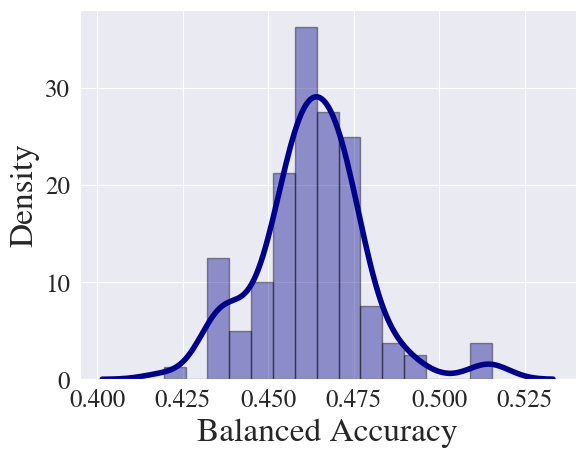

Anderson-Darling test for normality on data set 'left' -- 'diff':
AndersonResult(statistic=1.368225116549766, critical_values=array([0.559, 0.637, 0.764, 0.891, 1.06 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.4627725626815268, scale=0.01575369355702898)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set 'left' -- 'right':
ShapiroResult(statistic=0.9859164357185364, pvalue=0.22360675036907196)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


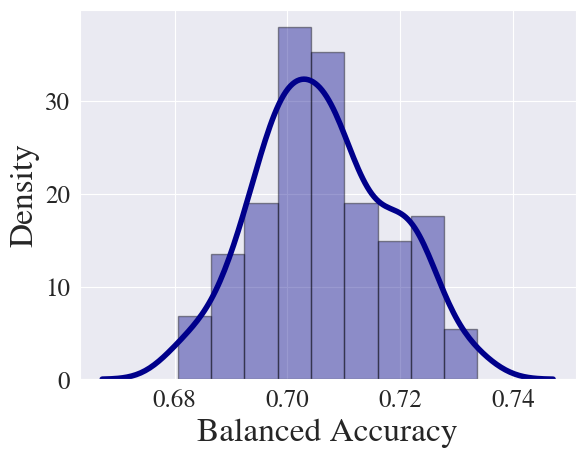

Anderson-Darling test for normality on data set 'left' -- 'right':
AndersonResult(statistic=0.5662897432578404, critical_values=array([0.559, 0.637, 0.764, 0.891, 1.06 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.7063517331280158, scale=0.011748796884685067)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set 'left+diff' -- 'right+diff':
ShapiroResult(statistic=0.9627196788787842, pvalue=0.0016106796683743596)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


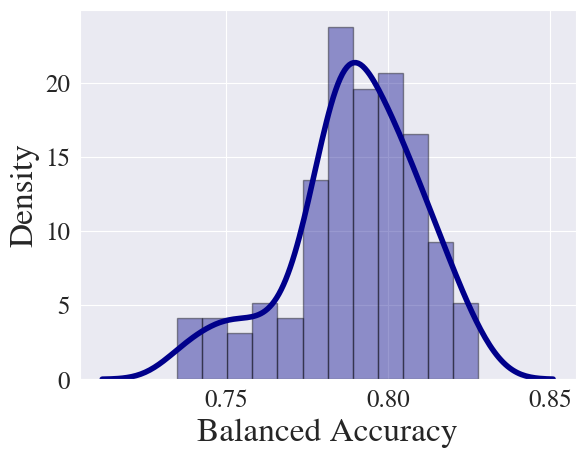

Anderson-Darling test for normality on data set 'left+diff' -- 'right+diff':
AndersonResult(statistic=1.2936570587974217, critical_values=array([0.559, 0.637, 0.764, 0.891, 1.06 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.7898053325172911, scale=0.020163020086980604)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set 'left+right' -- 'left+diff':
ShapiroResult(statistic=0.9618745446205139, pvalue=0.0013672165805473924)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


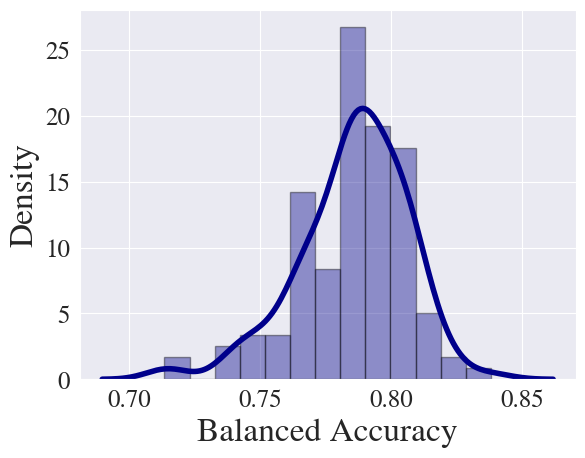

Anderson-Darling test for normality on data set 'left+right' -- 'left+diff':
AndersonResult(statistic=1.2581640962918073, critical_values=array([0.559, 0.637, 0.764, 0.891, 1.06 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.7855134663322634, scale=0.02079636825023472)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set 'left+right' -- 'right+diff':
ShapiroResult(statistic=0.9737065434455872, pvalue=0.015315164811909199)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


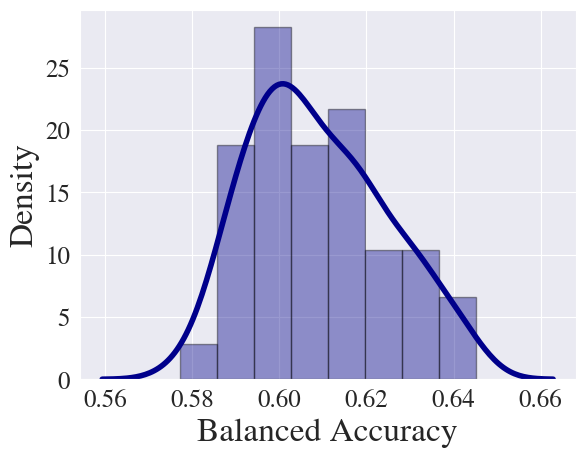

Anderson-Darling test for normality on data set 'left+right' -- 'right+diff':
AndersonResult(statistic=0.9796660288962187, critical_values=array([0.559, 0.637, 0.764, 0.891, 1.06 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.6089347641663028, scale=0.015559604082737174)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set 'right' -- 'diff':
ShapiroResult(statistic=0.9561355113983154, pvalue=0.0004648812173400074)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


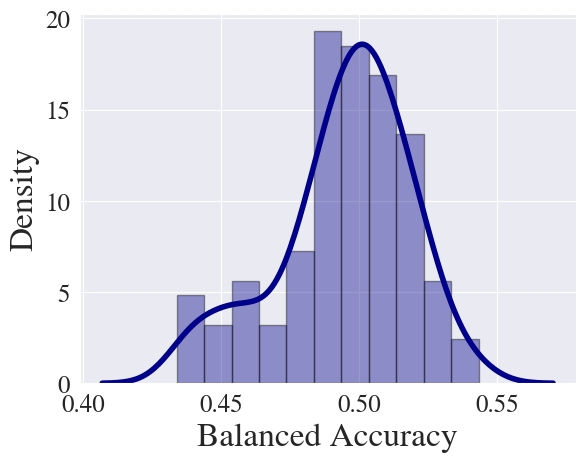

Anderson-Darling test for normality on data set 'right' -- 'diff':
AndersonResult(statistic=1.8133560692252928, critical_values=array([0.559, 0.637, 0.764, 0.891, 1.06 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.49463932815901496, scale=0.02362151309920786)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set diff -- diff:
ShapiroResult(statistic=0.9983518719673157, pvalue=0.827066957950592)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


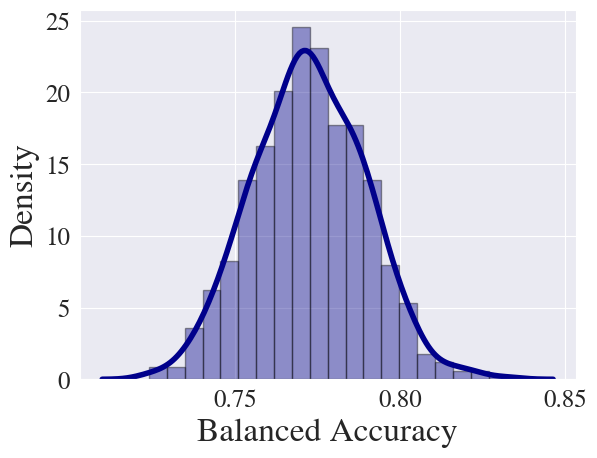

Anderson-Darling test for normality on data set diff -- diff:
AndersonResult(statistic=0.17593410891720396, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.772485431716697, scale=0.01704924031370106)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set left+diff -- left+diff:
ShapiroResult(statistic=0.9838986396789551, pvalue=2.2079098016547505e-06)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


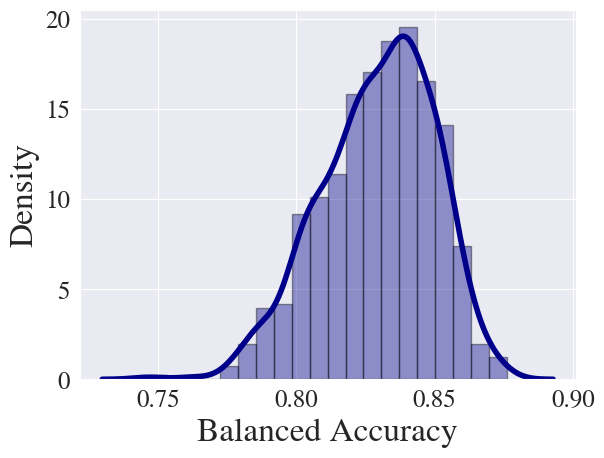

Anderson-Darling test for normality on data set left+diff -- left+diff:
AndersonResult(statistic=2.680851900538528, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.8293962214690517, scale=0.020301874909602478)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set left+right+diff -- left+right+diff:
ShapiroResult(statistic=0.9880338907241821, pvalue=5.4380194342229515e-05)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


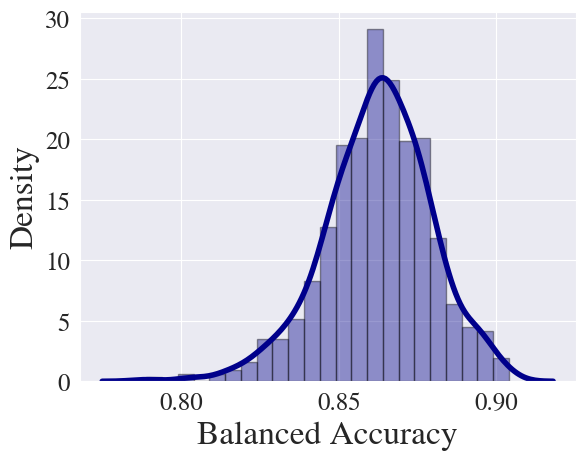

Anderson-Darling test for normality on data set left+right+diff -- left+right+diff:
AndersonResult(statistic=1.337164560973065, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.8623584051693324, scale=0.016943829325826405)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set left+right -- left+right:
ShapiroResult(statistic=0.9788680076599121, pvalue=7.569860116518612e-08)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


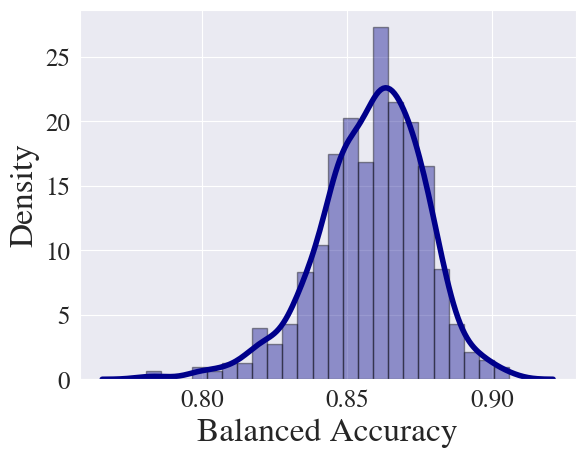

Anderson-Darling test for normality on data set left+right -- left+right:
AndersonResult(statistic=2.692964012526545, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.8583103799686492, scale=0.018339660820040283)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set left -- left:
ShapiroResult(statistic=0.9713659882545471, pvalue=1.0594807253738736e-09)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


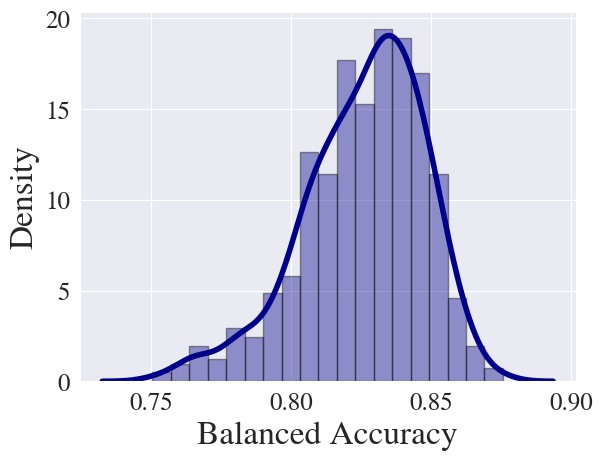

Anderson-Darling test for normality on data set left -- left:
AndersonResult(statistic=4.296499275445967, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.8258242371554719, scale=0.021705277400088364)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set right+diff -- right+diff:
ShapiroResult(statistic=0.9917576313018799, pvalue=0.001512802904471755)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


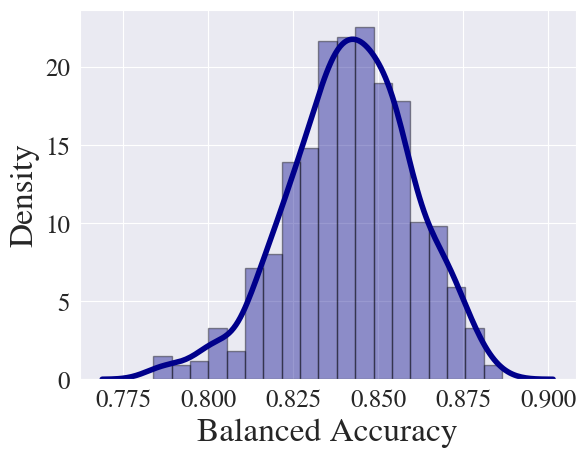

Anderson-Darling test for normality on data set right+diff -- right+diff:
AndersonResult(statistic=0.7122610600735015, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.8416644707730339, scale=0.01818688901056388)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set right -- right:
ShapiroResult(statistic=0.9896950721740723, pvalue=0.00022630931925959885)


/Users/leonardoalchieri/mambaforge/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


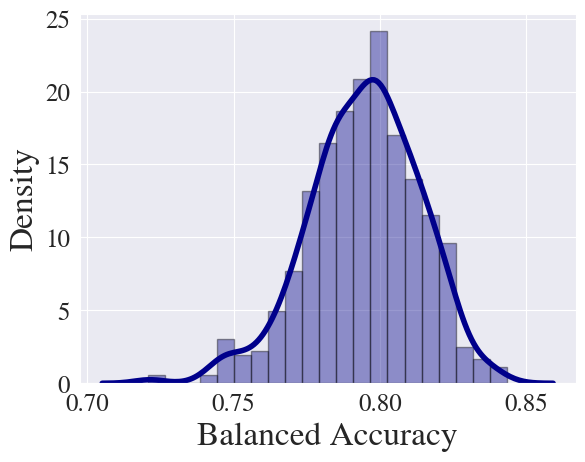

Anderson-Darling test for normality on data set right -- right:
AndersonResult(statistic=0.9813730547298292, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.7945589689952711, scale=0.018992157607279347)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [62]:
test_normality(all_xgb_results=all_xgb_results)

Statistical tests say that the distributions are not normal. But upon visual inspection, they are not far from a normal. As such, the t-test should be able handle this data, since with n>30 it is still robust to non-normality.

In [63]:
n_tot = 4873
n1 = 4/5 * n_tot
n2 = 1/5 * n_tot

In [64]:
t_test_results = corrected_t_test(df=all_seed_avgs, 
                               side_combinations=side_combinations, n1=n1, n2=n2)

This t test evaluated the mean and standard deviation directly. However, a stronger approach would be to use the calculate standard deviation. I perform this in the average part.

In [66]:
t_test_results = pd.DataFrame.from_dict(t_test_results, orient='index', columns=['t', 'p-value', 'p > 0.05'])
display(t_test_results)

,t,p-value,p > 0.05
"('left' -- 'diff', 'left' -- 'right')",-25.525216,2.851088e-50,False
"('left' -- 'diff', 'left+diff' -- 'right+diff')",-25.667842,1.594255e-50,False
"('left' -- 'diff', 'left+right' -- 'left+diff')",-25.496649,3.161768e-50,False
"('left' -- 'diff', 'left+right' -- 'right+diff')",-14.295866,1.046111e-26,False
"('left' -- 'diff', 'right' -- 'diff')",-2.256640,2.058097e-01,False
...,...,...,...
"(left+right -- left+right, right+diff -- right+diff)",4.486991,2.385126e-04,False
"(left+right -- left+right, right -- right)",14.462917,4.263946e-27,False
"(left -- left, right+diff -- right+diff)",-3.272018,1.510027e-02,False
"(left -- left, right -- right)",6.388495,5.866379e-08,False
